In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os; import sys
import numpy as np
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [4]:
# MPC import
from MPCVelControl_D5_1 import MPCVelControl
from PIControl.PIControl import PIControl

from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [ ]:
Ts = 0.05
sim_time = 15; 
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

Maximum invariant set successfully computed after 11 iterations.
Maximum invariant set successfully computed after 11 iterations.
Maximum invariant set successfully computed after 1 iterations.
Maximum invariant set successfully computed after 18 iterations.


In [10]:
print(mpc.mpc_z.A)
print(mpc.mpc_z.B)
print(mpc.mpc_z.nu)
print(mpc.mpc_z.nx)

[[1.]]
[[0.0073545]]
1
1


## Observer design

In [99]:
d = np.array([-2])

A = mpc.mpc_z.A
B = mpc.mpc_z.B
nx = mpc.mpc_z.nx
nu = mpc.mpc_z.nu
ny = nu
nd = nu
# x^+ = A x + B u + B d
# d^+ = d
# y   = 1 x + 0 d 

# A_hat = [A  Bd;  0 I] = [A  B; 0  I]
A_hat = np.vstack((
    np.hstack((A, B)),
    np.hstack((np.zeros((ny, nx)), np.eye(ny))))
)

# B_hat = [B; 0]
B_hat = np.vstack((B, np.zeros((nd, nu))))

# C_hat = [C  Cd] = [1 0]
C_hat = np.hstack((np.eye(ny,nd), np.zeros((ny,nd))))

print(A_hat)
print(B_hat)
print(C_hat)

poles = np.array([0.8, 0.7])
from scipy.signal import place_poles
res = place_poles(A_hat.T, C_hat.T, poles)
L = -res.gain_matrix.T

print(L)


[[1.        0.0073545]
 [0.        1.       ]]
[[0.0073545]
 [0.       ]]
[[1. 0.]]
[[-0.5       ]
 [-8.15827045]]


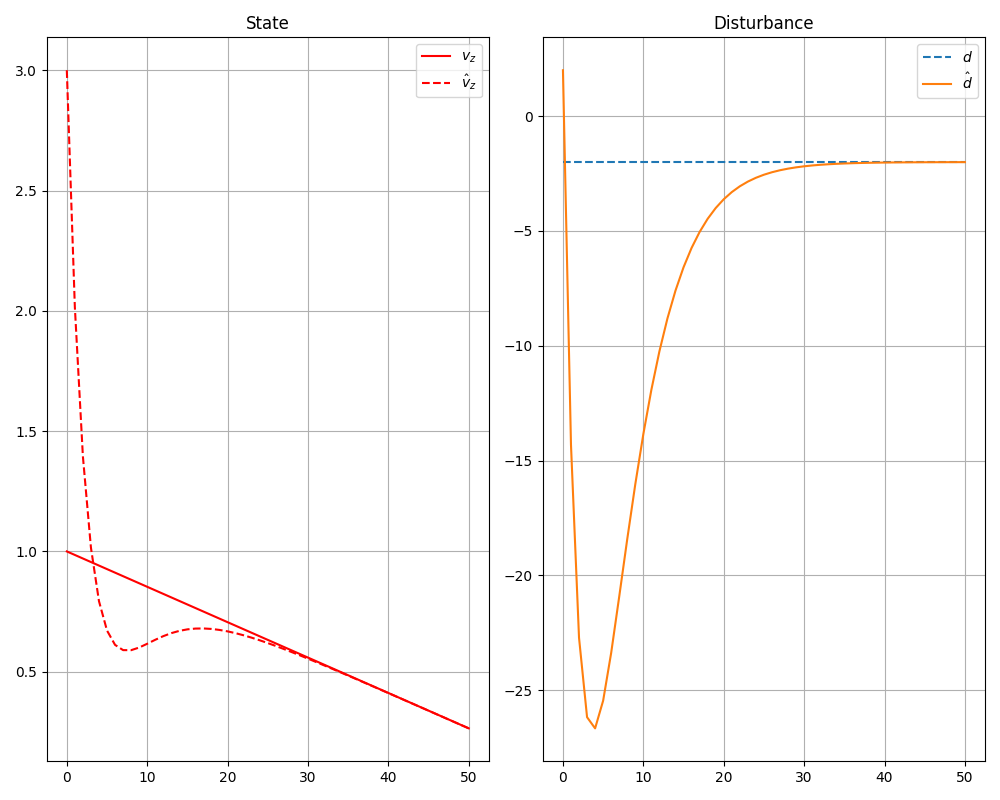

In [82]:
# Test with given initial condition
num_steps = 50
x_hat_traj = np.ndarray((num_steps+1, nx))  # estimated state trajectory
d_hat_traj = np.ndarray((num_steps+1, nd))  # estimated disturbance trajectory
x_traj = np.ndarray((num_steps+1, nx))      # true state trajectory
u_traj = np.zeros((num_steps, nu))          # input trajectory

x_hat_traj[0] = np.array([3])
d_hat_traj[0] = np.array([2])
x_traj[0] = np.array([1])

# Simulation
for k in range(num_steps):
	# True system
	x_traj[k+1] = A @ x_traj[k] + B @ d
	

	# Estimation	
	yk = x_traj[k]
	tmp = A_hat @ np.concatenate((x_hat_traj[k], d_hat_traj[k])) + L @ (x_hat_traj[k] - yk)
	x_hat_traj[k+1] = tmp[:nx]
	d_hat_traj[k+1] = tmp[nx:]

## Visualization

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from typing import Optional
def plot_trajs(
		x_hat_traj: np.ndarray,    # estimated states trajectory
		d_hat_traj: np.ndarray,    # estimated disturbance trajectory
		x_traj: np.ndarray,        # true states trajectory
		d: float,                  # true disturbance
		):

	fig, axs = plt.subplots(1, 2, figsize=(10, 8))

	# --- (1,1) x and x_hat ---
	axs[0].plot(x_traj[:], 'r', label=r'$v_z$')
	axs[0].plot(x_hat_traj[:], 'r--', label=r'$\hat{v}_z$')
	axs[0].set_title("State")
	axs[0].legend()
	axs[0].grid()

	# --- (1,2) d and d_hat ---
	axs[1].plot(d * np.ones_like(d_hat_traj), '--', label=r'$d$')
	axs[1].plot(d_hat_traj, label=r'$\hat{d}$')
	axs[1].set_title("Disturbance")
	axs[1].legend()
	axs[1].grid()

	plt.tight_layout()
	plt.show()


plot_trajs(x_hat_traj, d_hat_traj, x_traj, d)

In [104]:


Ts = 0.05
sim_time = 15; 
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Static mass change and zero fuel rate
rocket.mass = 1.5
rocket.fuel_rate = 0.0
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(mpc, sim_time, H, x0, x_target=x_target, method='nonlinear')





Maximum invariant set successfully computed after 11 iterations.
Maximum invariant set successfully computed after 11 iterations.


AttributeError: 'MPCControl_zvel_tuned_final' object has no attribute 'A_hat'

In [92]:
print(ref.shape)

(12, 301)


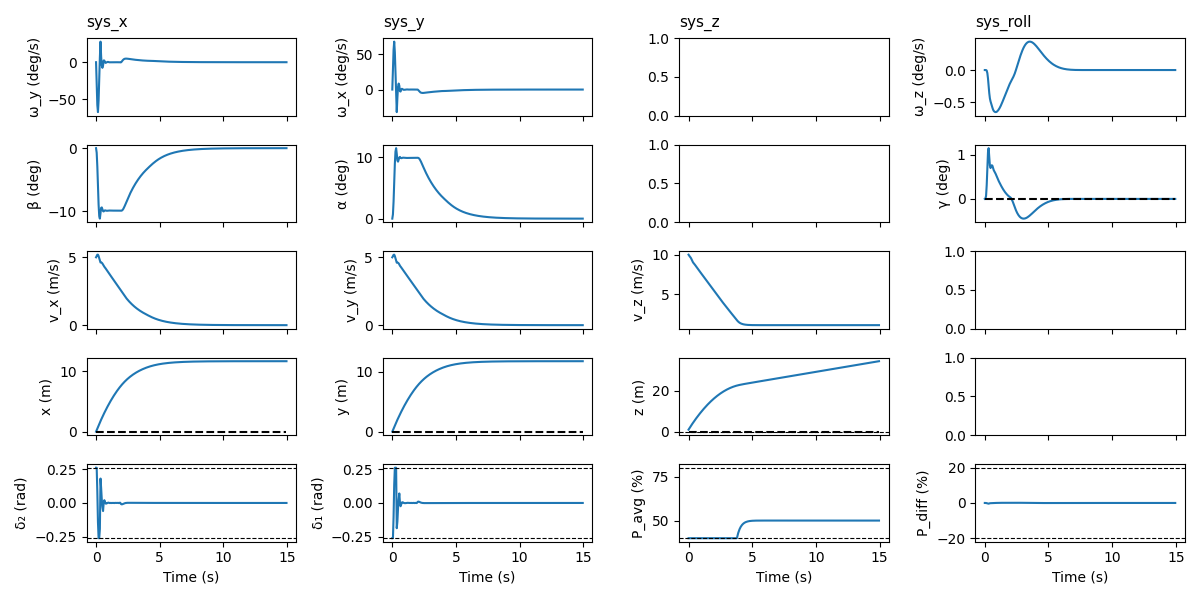

In [93]:
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, ref[:,:-1])

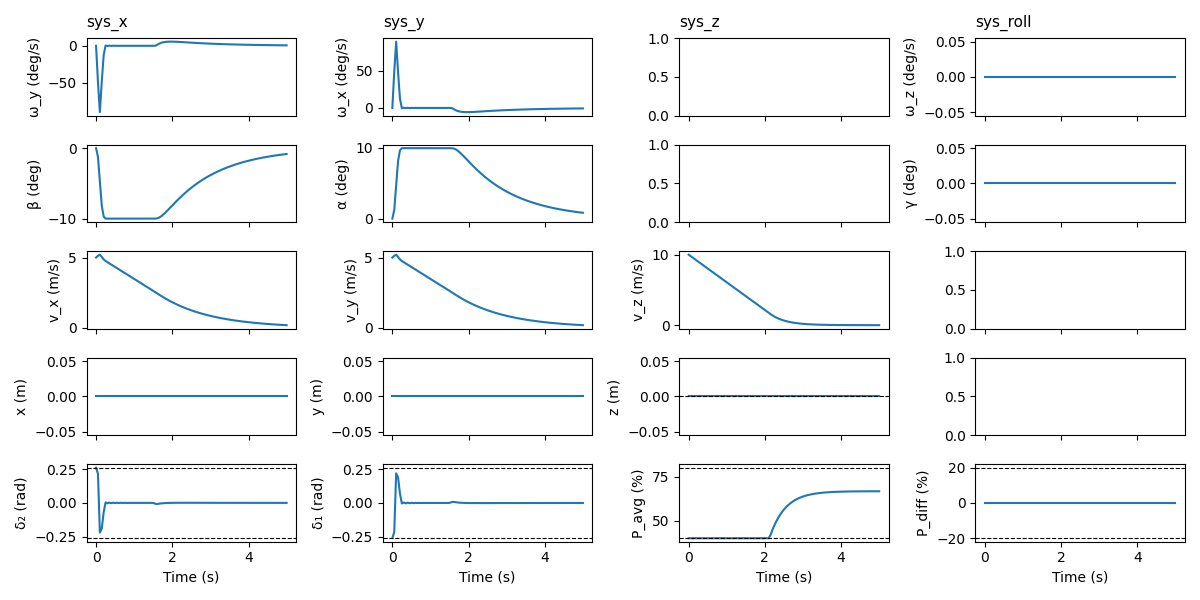

In [67]:
k = 0
u_at_step_1 = u_ol[:, :, k]  # Shape is (4, N_ol)
u_ol_padded = np.hstack((u_at_step_1, u_at_step_1[:, -1:]))
plot_static_states_inputs(t_ol[:, k], x_ol[:, :, k], u_ol_padded)

In [60]:
print(u_ol.shape)
print(sim_time / Ts)

(4, 100, 200)
200.0


In [86]:
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
#vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, Ref=ref[:,:-1], T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol); 
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl); 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

In [ ]:

class BaseController:
    def __init__(self, name):
        self.name = name

    def get_u(self):
        print("yallah")

# 2. The Standard Classes (Inherit only)
class StandardControllerA(BaseController):
    pass

class StandardControllerB(BaseController):
    pass

class StandardControllerC(BaseController):
    pass

# 3. The Special Class (Overwrites get_u)
class SpecialControllerD(BaseController):
    def get_u(self):
        print("ok good!")

# --- TEST PROGRAM ---

# Create a list of all 4 controllers
controllers = [
    StandardControllerA("Controller A"),
    StandardControllerB("Controller B"),
    StandardControllerC("Controller C"),
    SpecialControllerD("Controller D (Special)")
]



for ctrl in controllers:
    # Call the SAME function name on every object
    ctrl.get_u()

yallah
yallah
yallah
ok good!
